In [2]:
import bz2
import json
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import vaderSentiment
import fastparquet
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
import warnings
warnings.filterwarnings('ignore')

In [4]:
# If working locally :
data_path = 'data/'

# First approach of the sentiment analysis 

## Polarity scores of quotes using Vader & TextBlob

In [17]:
sid = SentimentIntensityAnalyzer()
text = "I am really extremely sad"
scores = sid.polarity_scores(text)
print(TextBlob(text).sentiment.polarity)
print(scores)

-0.5
{'neg': 0.479, 'neu': 0.521, 'pos': 0.0, 'compound': -0.5678}


## Extract only quotes from bz file (2012) for Obama

In [38]:
Obama_chunk = []
path_to_out = "obama_chunks.bz2"
with bz2.open('data/Quotebank/quotes-2012.json.bz2', 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
        for instance in tqdm(s_file):
            instance = json.loads(instance) # loading a sample
            speaker = instance['speaker'] # extracting list of links
            if 'obama' in speaker:
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

19849872it [11:54, 27770.05it/s]


In [43]:
quotes = []
index =0
with bz2.open('obama_chunks.bz2', 'rb') as s_file:
    for ins in tqdm(s_file): 
        quotes.append([(re.findall(rb"\"speaker\":.+(?=\"qids)",ins)),(re.findall(rb"\"quotation\":.+(?=\"speaker)",ins)),(re.findall(rb"\"date\":.+(?=\"numOccurrences)",ins))])
quotes = [[quotes[i][0][0].decode(),quotes[i][1][0].decode(),quotes[i][2][0].decode()] for i in range(len(quotes))]
quotes = [[i[0][11:-2],i[1][13:-3],i[2][8:-2]] for i in quotes]
df = pd.DataFrame(quotes,  columns =['Speaker','Quote','Date'])

273984it [00:17, 16073.56it/s]


In [44]:
quotes = [[quotes[i][0][0].decode(),quotes[i][1][0].decode(),quotes[i][2][0].decode()] for i in range(len(quotes))]



In [45]:
quotes = [[i[0][11:-2],i[1][13:-3],i[2][8:-2]] for i in quotes]


In [46]:
df = pd.DataFrame(quotes,  columns =['Speaker','Quote','Date'])

In [53]:
df

,Speaker,Quote,Date
0,"""barack obama""","""a president is supposed to lead the charge to...","""2012-09-05 18:28:38"""
1,"""president obama""","""a small group of friends and aides that inclu...","""2012-08-05 04:34:08"""
2,"""barack obama""","""absolutely not. not at this age,","""2012-11-06 05:00:00"""
3,"""president obama""","""Al Qaeda has been decimated. Osama bin Laden ...","""2012-11-01 17:17:43"""
4,"""president obama""","""anytime you have a politician who has a track...","""2012-12-19 00:34:49"""
...,...,...,...
273979,"""barack obama""","""you better get your facts right","""2012-10-19 19:06:48"""
273980,"""president obama""","""you start to look and think, `are gay people ...","""2012-08-03 15:44:53"""
273981,"""president barack obama""","""your aunt betsy, who's got a real rabid appet...","""2012-09-20 18:22:46"""
273982,"""president obama""","""your loosing and its not looking like you can...","""2012-10-03 11:30:04"""


In [14]:
df['Speaker'].value_counts()[:23]

None                      138611
mitt romney                26926
president obama            13580
president barack obama     13080
barack obama                5870
rick santorum               4911
newt gingrich               4220
paul ryan                   3957
ron paul                    2493
hillary clinton             2401
david cameron               2395
chris christie              1995
joe biden                   1735
thomas more                 1666
tiger woods                 1665
john boehner                1575
scott walker                1562
vladimir putin              1508
trayvon martin              1500
whitney houston             1492
manmohan singh              1489
justin bieber               1480
tim tebow                   1406
Name: Speaker, dtype: int64

In [62]:
def AnalyseSpeaker(speaker):
    speaker_df = df.loc[df['Speaker'].str.contains(speaker, case=False)]
    speaker_df['TextBlob'] = speaker_df.apply(lambda row: TextBlob(row.Quote).sentiment.polarity,  axis = 1)
    #speaker_df['Vader_pos'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['pos'],  axis = 1)
    #speaker_df['Vader_neg'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['neg'],  axis = 1)
    speaker_df['Vader_com'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['compound'],  axis = 1)
    #speaker_df['Vader_neu'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['neu'],  axis = 1)
    speaker_df['mean_vader_blob'] = speaker_df.apply(lambda row: np.mean([row.TextBlob, row.Vader_com]),  axis = 1)
    speaker_df = speaker_df.reset_index()

    
    return speaker_df


In [63]:
Obama_df = AnalyseSpeaker('obama')
mitt_df = AnalyseSpeaker('mitt romney')
hill_df = AnalyseSpeaker('hillary clinton')

In [67]:
Obama_df

,index,Speaker,Quote,Date,TextBlob,Vader_com,mean_vader_blob
0,0,"""barack obama""","""a president is supposed to lead the charge to...","""2012-09-05 18:28:38""",0.000000,0.0000,0.000000
1,1,"""president obama""","""a small group of friends and aides that inclu...","""2012-08-05 04:34:08""",-0.050000,0.4767,0.213350
2,2,"""barack obama""","""absolutely not. not at this age,","""2012-11-06 05:00:00""",-0.100000,0.0000,-0.050000
3,3,"""president obama""","""Al Qaeda has been decimated. Osama bin Laden ...","""2012-11-01 17:17:43""",-0.200000,-0.6486,-0.424300
4,4,"""president obama""","""anytime you have a politician who has a track...","""2012-12-19 00:34:49""",0.300000,0.1935,0.246750
...,...,...,...,...,...,...,...
273979,273979,"""barack obama""","""you better get your facts right","""2012-10-19 19:06:48""",0.392857,0.4404,0.416629
273980,273980,"""president obama""","""you start to look and think, `are gay people ...","""2012-08-03 15:44:53""",0.008333,-0.3570,-0.174333
273981,273981,"""president barack obama""","""your aunt betsy, who's got a real rabid appet...","""2012-09-20 18:22:46""",0.200000,0.0000,0.100000
273982,273982,"""president obama""","""your loosing and its not looking like you can...","""2012-10-03 11:30:04""",0.000000,-0.6818,-0.340900


In [75]:
test = testdf['mean_vader_blob'].resample(freq).mean()
test.plot(linewidth=0.5)

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [52]:
freq = 'D'
Obama_day_mean = Obama_df['mean_vader_blob'].resample(freq).mean()
Romney_day_mean = mitt_df['mean_vader_blob'].resample(freq).mean()
Hillary_day_mean = hill_df['mean_vader_blob'].resample(freq).mean()

fig, axs = plt.subplots(3,sharex=True,figsize=(15,10))
axs[0].title.set_text('Obama sentiment Plot')
axs[1].title.set_text('Romney sentiment Plot')
axs[2].title.set_text('Hillary sentiment Plot')

Obama_day_mean.plot(linewidth=0.5,ax = axs[0])
Romney_day_mean.plot(linewidth=0.5,ax=axs[1])
Hillary_day_mean.plot(linewidth=0.5,ax=axs[2])


AttributeError: 'NaTType' object has no attribute 'tz'

In [9]:
sentiments = []
neg = []
pos = []
neu = []
com = []
min_blob_vader_pos = []
max_blob_vader_pos= []
mean_scores = []
blobscores = []
for i in tqdm(quotes):
    scores = sid.polarity_scores(i)
    neg.append(scores['neg'])
    neu.append(scores['neu'])
    pos.append(scores['pos'])
    com.append(scores['compound'])
    # adjust blobscore btw 0 and 1
    blobscore = TextBlob(i).sentiment.polarity
    blobscores.append(blobscore)
    if blobscore>0 and scores['pos']> 0:
        max_blob_vader_pos.append(max(scores['pos'],blobscore ))
        mean_scores.append(np.mean([scores['pos'],blobscore]))

    if blobscore<0 and scores['neg'] > 0:
        min_blob_vader_pos.append(max(scores['neg'],-blobscore ))
        mean_scores.append(np.mean([-scores['neg'],blobscore]))
    


  1%|▏         | 20792/1446436 [00:09<09:35, 2479.34it/s]
1445753it [01:00, 32839.28it/s][00:09<09:17, 2558.30it/s]
  4%|▍         | 64256/1446436 [00:27<09:28, 2431.16it/s]


  9%|▉         | 128033/1446436 [00:55<09:02, 2430.22it/s]


 13%|█▎        | 193290/1446436 [01:22<08:42, 2399.63it/s]


 18%|█▊        | 258239/1446436 [01:49<08:10, 2420.95it/s]


 22%|██▏       | 323211/1446436 [02:16<08:07, 2302.18it/s]


 27%|██▋       | 388519/1446436 [02:43<07:12, 2446.23it/s]


 31%|███▏      | 453736/1446436 [03:10<06:54, 2392.59it/s]


 36%|███▌      | 518642/1446436 [03:37<06:21, 2435.15it/s]


 40%|████      | 583828/1446436 [04:04<05:50, 2459.74it/s]


 45%|████▍     | 648081/1446436 [04:32<05:40, 2346.53it/s]


 49%|████▉     | 712745/1446436 [04:59<05:22, 2271.69it/s]


 54%|█████▍    | 777603/1446436 [05:26<04:50, 2304.02it/s]


 58%|█████▊    | 842086/1446436 [05:53<04:16, 2357.30it/s]


 63%|██████▎   | 907007/1446436 [06:20<03:42, 2419.02it/s]


 67%|██████▋   | 971323/1446436 [06:47<03:19, 2384.48it/s]


 72%|███████▏  | 1035357/1446436 [07:14<02:52, 2378.49it/s]


 76%|███████▌  | 1098556/1446436 [07:41<02:30, 2306.56it/s]


 80%|████████  | 1161067/1446436 [08:08<02:04, 2291.94it/s]


 85%|████████▍ | 1223360/1446436 [08:35<01:34, 2363.17it/s]


 89%|████████▉ | 1285686/1446436 [09:01<01:10, 2286.65it/s]


 93%|█████████▎| 1351966/1446436 [09:28<00:39, 2391.50it/s]


 98%|█████████▊| 1413976/1446436 [09:55<00:14, 2304.59it/s]


100%|██████████| 1446436/1446436 [10:09<00:00, 2372.74it/s]


In [36]:
import seaborn as sns

In [12]:
len(quotes)

1446436

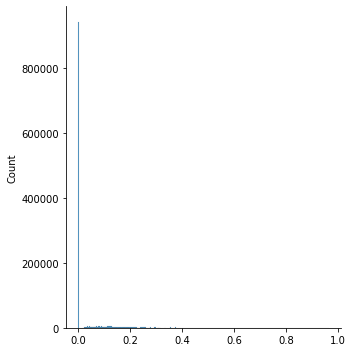

In [13]:

sns.displot(neg)

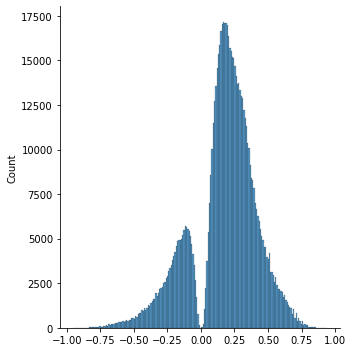

In [14]:

sns.displot(mean_scores, bins = 200)


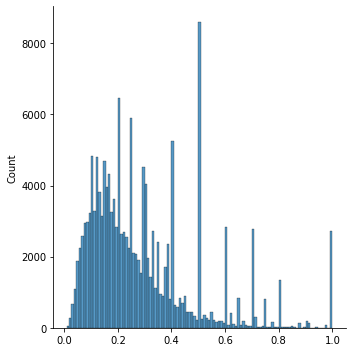

In [15]:
sns.displot(min_blob_vader_pos)

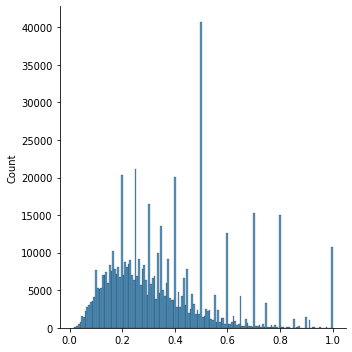

In [16]:
sns.displot(max_blob_vader_pos)

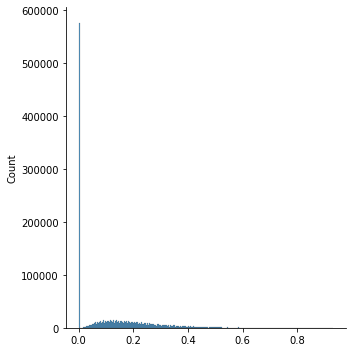

In [17]:
sns.displot(pos)

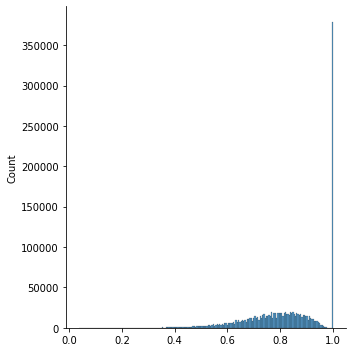

In [18]:
sns.displot(neu)

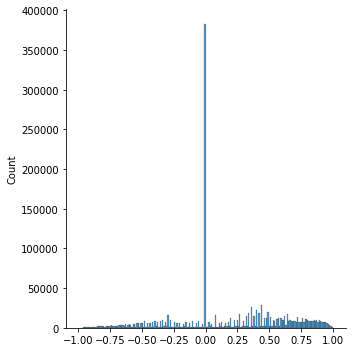

In [19]:
sns.displot(com)

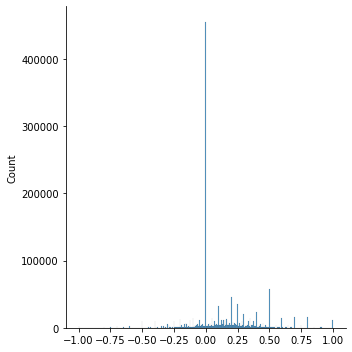

In [22]:
sns.displot(blobscores)

### MEDICAL CLUSTER PLOTS

In [3]:
# load clusters. Medical cluster is N°2
cluster = pd.read_parquet('data/cluster.parquet')

In [4]:
# create dictionnary of speakers id -> [occupations]
medical = cluster.loc[cluster['cluster']==2]
medicalIdList = medical.ID.to_list()
speaker_attributes = pd.read_parquet('data/speaker_attributes.parquet')
dict_SId_OccId = dict(zip(speaker_attributes.id, speaker_attributes.occupation))


In [ ]:
assert False
#create medical bz2 file of quotes for 2012 quotes.
path_to_out = "medical_2012.bz2"
with bz2.open('data/Quotebank/quotes-2012.json.bz2', 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
        for instance in tqdm(s_file):
            #print(instance)
            instance = json.loads(instance) # loading a sample
            id_ = instance['qids']
            for quid in id_:
                occupations = dict_SId_OccId.get(str(quid))
                if (not (occupations is None)) and (set(occupations) & set(medicalIdList)):
                    #print('id:',id_,'occ:', occupations)
                    d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

In [5]:
#complete medical ds with all years 2008-2016:
for i in range(9,17):
    if i != 12:
        print("working on medical_20{:02d}.bz2".format(i))
        path_to_out = "medical_20{:02d}.bz2".format(i)
        with bz2.open("data/Quotebank/quotes-20{:02d}.json.bz2".format(i), 'rb') as s_file:
            with bz2.open(path_to_out, 'wb') as d_file:
                for instance in tqdm(s_file):
                    instance = json.loads(instance) # loading a sample
                    id_ = instance['qids']
                    for quid in id_:
                        occupations = dict_SId_OccId.get(str(quid))
                        if (not (occupations is None)) and (set(occupations) & set(medicalIdList)):
                            #print('id:',id_,'occ:', occupations)
                            d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

1974it [00:00, 19725.49it/s]

working on medical_2009.bz2


19567082it [13:25, 24284.12it/s]
2224it [00:00, 22214.65it/s]

working on medical_2010.bz2


17208434it [11:49, 24250.26it/s]
5053it [00:00, 24896.47it/s]

working on medical_2011.bz2


19632724it [12:48, 25542.06it/s]
2289it [00:00, 22888.55it/s]

working on medical_2013.bz2


18614447it [11:28, 27041.04it/s]
5285it [00:00, 25913.66it/s]

working on medical_2014.bz2


19896843it [12:05, 27407.09it/s]
2501it [00:00, 22894.33it/s]

working on medical_2015.bz2


20874338it [13:17, 26184.60it/s]
2418it [00:00, 21215.30it/s]

working on medical_2016.bz2


13862129it [09:05, 25424.16it/s]


In [161]:
#load all medical speakers quotes from 2012
quotes = []
index =0
with bz2.open('medical_2012.bz2', 'rb') as s_file:
    for ins in tqdm(s_file): 
        quotes.append([(re.findall(rb"\"speaker\":.+(?=\"qids)",ins)),(re.findall(rb"\"quotation\":.+(?=\"speaker)",ins)),(re.findall(rb"\"date\":.+(?=\"numOccurrences)",ins))])
quotes = [[quotes[i][0][0].decode(),quotes[i][1][0].decode(),quotes[i][2][0].decode()] for i in range(len(quotes))]
quotes = [[i[0][11:-2],i[1][13:-3],i[2][8:-2]] for i in quotes]
medical_df = pd.DataFrame(quotes,  columns =['speaker','quote','date'])





0it [00:00, ?it/s]



1753it [00:00, 17525.42it/s]



3974it [00:00, 18708.99it/s]



6053it [00:00, 19287.27it/s]



8162it [00:00, 19495.28it/s]



10311it [00:00, 20051.24it/s]



12349it [00:00, 20146.52it/s]



14690it [00:00, 21024.68it/s]



16666it [00:00, 19300.44it/s]



18535it [00:00, 18968.59it/s]



20391it [00:01, 18655.49it/s]



22229it [00:01, 18322.86it/s]



26030it [00:01, 19505.00it/s]


In [166]:
sid = SentimentIntensityAnalyzer()

def sentiment(df):
    '''
    Add to quotes dataframe df evaluations of the quote's sentiment
    '''
    df['TextBlob'] = df.apply(lambda row: TextBlob(row.quote).sentiment.polarity,  axis = 1)
    #speaker_df['Vader_pos'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['pos'],  axis = 1)
    #speaker_df['Vader_neg'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['neg'],  axis = 1)
    df['Vader_com'] = df.apply(lambda row: sid.polarity_scores(row.quote)['compound'],  axis = 1)
    #speaker_df['Vader_neu'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['neu'],  axis = 1)
    df['mean_vader_blob'] = df.apply(lambda row: np.mean([row.TextBlob, row.Vader_com]),  axis = 1)
    df = df.reset_index()

    
    return df

In [167]:

sentiment(medical_df)

,index,speaker,quote,date,TextBlob,Vader_com,mean_vader_blob
0,0,"""susan powell""","""at her naked body under the bathroom door","""2012-08-09 22:00:00""",0.000000,0.0000,0.000000
1,1,"""faye wattleton""","""corporate support was only about 5% of our bu...","""2012-02-07 13:24:10""",0.000000,0.4019,0.200950
2,2,"""david green""","""fraud squad's new bruiser","""2012-11-10 00:10:00""",0.136364,-0.5859,-0.224768
3,3,"""anne haug""","""i had a good race, but i didn't have the fini...","""2012-10-20 03:18:12""",0.300000,0.5106,0.405300
4,4,"""marion jones""","""i sat down with her and she told me track is ...","""2012-08-08 20:36:38""",0.422222,0.6369,0.529561
...,...,...,...,...,...,...,...
26025,26025,"""john johnson""","""i just want to say thank you for everybody to...","""2012-06-01 02:34:21""",0.000000,0.6705,0.335250
26026,26026,"""stuart altman""","""i think it's going to take a lot of our time ...","""2012-11-17 00:21:57""",0.278571,0.4576,0.368086
26027,26027,"""abdul rahman""","""kuwaiti politicians reject bassil visit over ...","""2012-03-12 05:21:24""",0.000000,-0.4019,-0.200950
26028,26028,"""jade goody""","""that's your mummy. she's on her way now","""2012-01-26 00:00:00""",0.000000,0.0000,0.000000


In [168]:
#put date into datetime format
medical_df['date'] = pd.to_datetime(medical_df['date'],format="\"%Y-%m-%d %H:%M:%S\"")

In [171]:
#set date as index for plotting
medical_df.set_index('date', inplace=True)

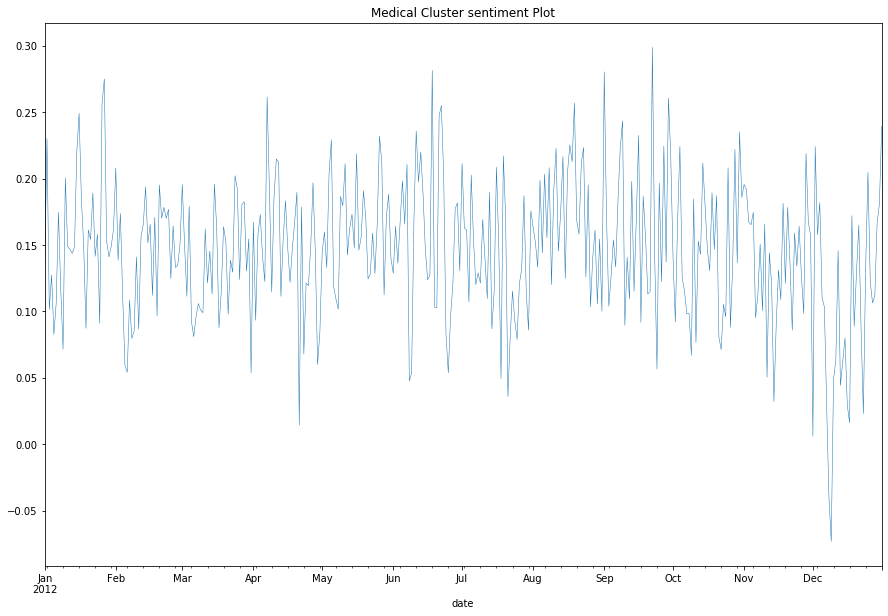

In [180]:
#frequency freq: D-day, W-week, M-month, Y-year...
freq = 'D'
medical_mean = medical_df['mean_vader_blob'].resample(freq).mean()
fig, axs = plt.subplots(sharex=True,figsize=(15,10))
axs.title.set_text('Medical Cluster sentiment Plot')


medical_mean.plot(linewidth=0.5,ax = axs)
